In [64]:
import pickle
import numpy as np
import pickle
import sys
import random

sys.path.append('../')
from riskrrt import RiskRRT
from utils import *
from biriskrrt import BiRiskRRT, BiRiskRRTPed, TrajReader
from param import BiParams
from utils import OccupancyGrid, generateSimulationVideo
import cv2
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm


In [2]:
with open('../results/imitation_dataset/all_scenes.pkl', 'rb') as f:
    scenes = pickle.load(f)

In [3]:
len(scenes)

900

In [4]:
for i in range(20):
    print(len(scenes[i]['pedestrians'][0]))

2
8
2
2
9
2
2
9
2
2
2
8
2
9
9
8
8
9
8
9


In [8]:

n_peds = []
for i in range(900):
    n_peds.append(max(max([[a[0] for a in time] for time in scenes[i]['pedestrians']])))


In [13]:
np.mean(n_peds), np.max(n_peds)

(19.102222222222224, 31)

(array([ 16.,  59.,  78., 140., 301., 190.,  18.,  11.,   3.,  84.]),
 array([ 9. , 11.2, 13.4, 15.6, 17.8, 20. , 22.2, 24.4, 26.6, 28.8, 31. ]),
 <BarContainer object of 10 artists>)

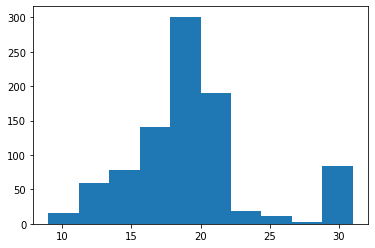

In [14]:
# number of total pedestrians
plt.hist(n_peds)

In [16]:

n_peds = []
for i in range(900):
    n_peds.append(max([len(time) for time in scenes[i]['pedestrians']]))


In [17]:
np.mean(n_peds), np.max(n_peds)

(10.372222222222222, 12)

(array([  2.,   0.,   0., 117.,   0.,   8., 326.,   0., 309., 138.]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <BarContainer object of 10 artists>)

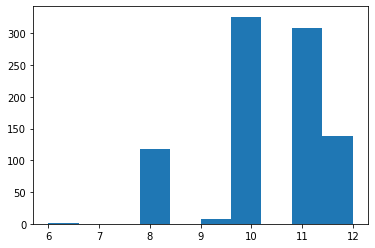

In [18]:
# number of max simultaneous pedestrians
plt.hist(n_peds)


we can use 12 agents max.

In [38]:
np.array(scenes[1]['traj'][1][:2])


array([  0.02666553, -11.49978667])

In [28]:
peds = np.array(scenes[1]['pedestrians'][1])[:,1:]
padded = np.pad(peds, ((0, 12-peds.shape[0]),(0,0)))

(8, 2)

In [34]:
np.pad(peds, ((0, 12-peds.shape[0]),(0,0)))

array([[ 5.93518564, -1.0621133 ],
       [ 5.82532285, -0.5699968 ],
       [ 4.50465429, -0.48646587],
       [ 4.38237406,  0.21113673],
       [ 1.36051601, -0.63634422],
       [ 1.61075903, -1.58430095],
       [-0.21460487, -1.3103195 ],
       [-2.44553503,  2.2743507 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

### pad for all data

In [52]:
def prepare_scene(scene):
    all_peds = scene['pedestrians']
    all_traj = scene['traj']
    trajectroy = []
    all_peds_padded = []
    for t in range(len(all_peds)):
        peds = np.array(all_peds[t])[:,1:]
        padded = np.pad(peds, ((0, 12-peds.shape[0]),(0,0)))
        all_peds_padded.append(padded)
        trajectroy.append(all_traj[t][:2])

    
    all_peds_padded = np.stack(all_peds_padded)
    trajectroy = np.array(trajectroy)
    
    return (all_peds_padded, trajectroy)

In [42]:
peds, traj = prepare_scene(scenes[0])

In [43]:
peds.shape, traj.shape

((55, 12, 2), (55, 2))

# simplest approach possible

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [50]:
# Custom Dataset class
class ForecastDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.targets[idx]
        return x, y

In [74]:
def process_scene(all_peds_padded, trajectroy):
    
    inputs, targets = [], []
    for t in range(len(trajectroy)-1):
        inputs.append( np.concatenate([trajectroy[t:t+1], all_peds_padded[t]]).flatten())
        targets.append(trajectroy[t+1])
    return inputs, targets 



inputs, targets = [], []
for s in tqdm(scenes):
    peds, traj = prepare_scene(s)
    i, t = process_scene( peds, traj)
    inputs.append(i)
    targets.append(t)


# Create Dataset and DataLoader
batch_size=24
dataset = ForecastDataset(torch.Tensor(np.concatenate(inputs)), torch.Tensor(np.concatenate(targets)))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|█████████████████████████████████████████████████████████████████| 900/900 [00:01<00:00, 811.47it/s]


In [75]:


class concept_network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(concept_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Hidden to output layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [83]:

# Parameters

input_size = 26 # 2(self) + 12 x 2(agents)
hidden_size = 128  # Number of neurons in hidden layer
output_size = 2  # xy coordinates for 

# Initialize the neural network
model = concept_network(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
# Example training loop
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for batch_inputs, batch_targets in data_loader:
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete.")

  1%|▋                                                                 | 10/1000 [00:10<17:03,  1.03s/it]

Epoch [10/1000], Loss: 118.4504


  2%|█▎                                                                | 20/1000 [00:20<16:38,  1.02s/it]

Epoch [20/1000], Loss: 103.5567


  3%|█▉                                                                | 30/1000 [00:30<16:21,  1.01s/it]

Epoch [30/1000], Loss: 96.9893


  4%|██▋                                                               | 40/1000 [00:41<16:34,  1.04s/it]

Epoch [40/1000], Loss: 93.2682


  5%|███▎                                                              | 50/1000 [00:51<16:07,  1.02s/it]

Epoch [50/1000], Loss: 90.4497


  6%|███▉                                                              | 60/1000 [01:01<16:19,  1.04s/it]

Epoch [60/1000], Loss: 88.1912


  7%|████▌                                                             | 70/1000 [01:11<15:43,  1.01s/it]

Epoch [70/1000], Loss: 86.7729


  8%|█████▎                                                            | 80/1000 [01:22<17:00,  1.11s/it]

Epoch [80/1000], Loss: 85.0352


  9%|█████▉                                                            | 90/1000 [01:34<17:07,  1.13s/it]

Epoch [90/1000], Loss: 83.8441


 10%|██████▌                                                          | 100/1000 [01:45<16:18,  1.09s/it]

Epoch [100/1000], Loss: 82.1960


 11%|███████▏                                                         | 110/1000 [01:55<15:26,  1.04s/it]

Epoch [110/1000], Loss: 81.5364


 12%|███████▊                                                         | 120/1000 [02:06<14:52,  1.01s/it]

Epoch [120/1000], Loss: 81.7341


 13%|████████▍                                                        | 130/1000 [02:16<15:03,  1.04s/it]

Epoch [130/1000], Loss: 80.7506


 14%|█████████                                                        | 140/1000 [02:26<14:44,  1.03s/it]

Epoch [140/1000], Loss: 80.6409


 15%|█████████▊                                                       | 150/1000 [02:37<15:02,  1.06s/it]

Epoch [150/1000], Loss: 79.9930


 16%|██████████▍                                                      | 160/1000 [02:47<14:21,  1.03s/it]

Epoch [160/1000], Loss: 79.9049


 17%|███████████                                                      | 170/1000 [02:57<13:55,  1.01s/it]

Epoch [170/1000], Loss: 78.7802


 18%|███████████▋                                                     | 180/1000 [03:08<13:49,  1.01s/it]

Epoch [180/1000], Loss: 78.6836


 19%|████████████▎                                                    | 190/1000 [03:18<13:36,  1.01s/it]

Epoch [190/1000], Loss: 78.3952


 20%|█████████████                                                    | 200/1000 [03:28<13:25,  1.01s/it]

Epoch [200/1000], Loss: 78.5858


 21%|█████████████▋                                                   | 210/1000 [03:38<13:15,  1.01s/it]

Epoch [210/1000], Loss: 78.4982


 22%|██████████████▎                                                  | 220/1000 [03:48<13:04,  1.01s/it]

Epoch [220/1000], Loss: 77.8803


 23%|██████████████▉                                                  | 230/1000 [03:58<12:55,  1.01s/it]

Epoch [230/1000], Loss: 77.5480


 24%|███████████████▌                                                 | 240/1000 [04:08<12:45,  1.01s/it]

Epoch [240/1000], Loss: 77.4060


 25%|████████████████▎                                                | 250/1000 [04:18<12:35,  1.01s/it]

Epoch [250/1000], Loss: 77.8903


 26%|████████████████▉                                                | 260/1000 [04:28<12:25,  1.01s/it]

Epoch [260/1000], Loss: 77.5081


 27%|█████████████████▌                                               | 270/1000 [04:38<12:15,  1.01s/it]

Epoch [270/1000], Loss: 76.7539


 28%|██████████████████▏                                              | 280/1000 [04:48<12:05,  1.01s/it]

Epoch [280/1000], Loss: 76.4628


 29%|██████████████████▊                                              | 290/1000 [04:58<11:53,  1.00s/it]

Epoch [290/1000], Loss: 76.2976


 30%|███████████████████▌                                             | 300/1000 [05:09<11:45,  1.01s/it]

Epoch [300/1000], Loss: 76.2536


 31%|████████████████████▏                                            | 310/1000 [05:19<11:34,  1.01s/it]

Epoch [310/1000], Loss: 75.9792


 32%|████████████████████▊                                            | 320/1000 [05:29<11:24,  1.01s/it]

Epoch [320/1000], Loss: 76.1389


 33%|█████████████████████▍                                           | 330/1000 [05:39<11:14,  1.01s/it]

Epoch [330/1000], Loss: 75.6971


 34%|██████████████████████                                           | 340/1000 [05:49<11:04,  1.01s/it]

Epoch [340/1000], Loss: 75.4449


 35%|██████████████████████▊                                          | 350/1000 [05:59<10:54,  1.01s/it]

Epoch [350/1000], Loss: 75.2504


 36%|███████████████████████▍                                         | 360/1000 [06:09<10:43,  1.01s/it]

Epoch [360/1000], Loss: 75.2340


 37%|████████████████████████                                         | 370/1000 [06:19<10:32,  1.00s/it]

Epoch [370/1000], Loss: 74.7395


 38%|████████████████████████▋                                        | 380/1000 [06:29<10:23,  1.01s/it]

Epoch [380/1000], Loss: 75.2749


 39%|█████████████████████████▎                                       | 390/1000 [06:39<10:16,  1.01s/it]

Epoch [390/1000], Loss: 74.7956


 40%|██████████████████████████                                       | 400/1000 [06:49<10:05,  1.01s/it]

Epoch [400/1000], Loss: 75.0417


 41%|██████████████████████████▋                                      | 410/1000 [06:59<09:53,  1.01s/it]

Epoch [410/1000], Loss: 74.5415


 42%|███████████████████████████▎                                     | 420/1000 [07:09<09:44,  1.01s/it]

Epoch [420/1000], Loss: 74.5600


 43%|███████████████████████████▉                                     | 430/1000 [07:20<09:33,  1.01s/it]

Epoch [430/1000], Loss: 74.3476


 44%|████████████████████████████▌                                    | 440/1000 [07:30<09:22,  1.00s/it]

Epoch [440/1000], Loss: 74.1934


 45%|█████████████████████████████▎                                   | 450/1000 [07:40<09:14,  1.01s/it]

Epoch [450/1000], Loss: 74.2302


 46%|█████████████████████████████▉                                   | 460/1000 [07:50<09:48,  1.09s/it]

Epoch [460/1000], Loss: 74.0026


 47%|██████████████████████████████▌                                  | 470/1000 [08:01<09:38,  1.09s/it]

Epoch [470/1000], Loss: 74.6324


 48%|███████████████████████████████▏                                 | 480/1000 [08:12<09:07,  1.05s/it]

Epoch [480/1000], Loss: 74.2360


 49%|███████████████████████████████▊                                 | 490/1000 [08:22<08:51,  1.04s/it]

Epoch [490/1000], Loss: 73.9011


 50%|████████████████████████████████▌                                | 500/1000 [08:32<08:36,  1.03s/it]

Epoch [500/1000], Loss: 74.0693


 51%|█████████████████████████████████▏                               | 510/1000 [08:43<08:28,  1.04s/it]

Epoch [510/1000], Loss: 73.9295


 52%|█████████████████████████████████▊                               | 520/1000 [08:53<08:22,  1.05s/it]

Epoch [520/1000], Loss: 73.6387


 53%|██████████████████████████████████▍                              | 530/1000 [09:04<08:09,  1.04s/it]

Epoch [530/1000], Loss: 73.7430


 54%|███████████████████████████████████                              | 540/1000 [09:14<07:59,  1.04s/it]

Epoch [540/1000], Loss: 73.7405


 55%|███████████████████████████████████▊                             | 550/1000 [09:25<07:48,  1.04s/it]

Epoch [550/1000], Loss: 73.6979


 56%|████████████████████████████████████▍                            | 560/1000 [09:35<07:34,  1.03s/it]

Epoch [560/1000], Loss: 73.5019


 57%|█████████████████████████████████████                            | 570/1000 [09:45<07:24,  1.03s/it]

Epoch [570/1000], Loss: 73.6570


 58%|█████████████████████████████████████▋                           | 580/1000 [09:55<07:10,  1.03s/it]

Epoch [580/1000], Loss: 72.9145


 59%|██████████████████████████████████████▎                          | 590/1000 [10:06<07:02,  1.03s/it]

Epoch [590/1000], Loss: 73.1811


 60%|███████████████████████████████████████                          | 600/1000 [10:16<06:51,  1.03s/it]

Epoch [600/1000], Loss: 72.9839


 61%|███████████████████████████████████████▋                         | 610/1000 [10:26<06:41,  1.03s/it]

Epoch [610/1000], Loss: 73.3619


 62%|████████████████████████████████████████▎                        | 620/1000 [10:37<06:33,  1.03s/it]

Epoch [620/1000], Loss: 73.1577


 63%|████████████████████████████████████████▉                        | 630/1000 [10:47<06:19,  1.03s/it]

Epoch [630/1000], Loss: 73.3690


 64%|█████████████████████████████████████████▌                       | 640/1000 [10:57<06:03,  1.01s/it]

Epoch [640/1000], Loss: 73.0618


 65%|██████████████████████████████████████████▎                      | 650/1000 [11:07<05:52,  1.01s/it]

Epoch [650/1000], Loss: 72.7417


 66%|██████████████████████████████████████████▉                      | 660/1000 [11:17<05:49,  1.03s/it]

Epoch [660/1000], Loss: 72.2693


 67%|███████████████████████████████████████████▌                     | 670/1000 [11:27<05:31,  1.01s/it]

Epoch [670/1000], Loss: 73.0756


 68%|████████████████████████████████████████████▏                    | 680/1000 [11:38<05:21,  1.00s/it]

Epoch [680/1000], Loss: 72.9804


 69%|████████████████████████████████████████████▊                    | 690/1000 [11:48<05:10,  1.00s/it]

Epoch [690/1000], Loss: 72.7725


 70%|█████████████████████████████████████████████▌                   | 700/1000 [11:58<05:01,  1.00s/it]

Epoch [700/1000], Loss: 72.3872


 71%|██████████████████████████████████████████████▏                  | 710/1000 [12:08<04:51,  1.00s/it]

Epoch [710/1000], Loss: 72.8084


 72%|██████████████████████████████████████████████▊                  | 720/1000 [12:18<04:40,  1.00s/it]

Epoch [720/1000], Loss: 72.5211


 73%|███████████████████████████████████████████████▍                 | 730/1000 [12:28<04:31,  1.00s/it]

Epoch [730/1000], Loss: 73.0115


 74%|████████████████████████████████████████████████                 | 740/1000 [12:38<04:20,  1.00s/it]

Epoch [740/1000], Loss: 72.4858


 75%|████████████████████████████████████████████████▊                | 750/1000 [12:48<04:10,  1.00s/it]

Epoch [750/1000], Loss: 72.4819


 76%|█████████████████████████████████████████████████▍               | 760/1000 [12:58<04:00,  1.00s/it]

Epoch [760/1000], Loss: 72.2600


 77%|██████████████████████████████████████████████████               | 770/1000 [13:08<03:51,  1.01s/it]

Epoch [770/1000], Loss: 72.3880


 78%|██████████████████████████████████████████████████▋              | 780/1000 [13:18<03:41,  1.01s/it]

Epoch [780/1000], Loss: 72.1069


 79%|███████████████████████████████████████████████████▎             | 790/1000 [13:28<03:31,  1.00s/it]

Epoch [790/1000], Loss: 72.1293


 80%|████████████████████████████████████████████████████             | 800/1000 [13:38<03:21,  1.01s/it]

Epoch [800/1000], Loss: 72.3545


 81%|████████████████████████████████████████████████████▋            | 810/1000 [13:48<03:10,  1.00s/it]

Epoch [810/1000], Loss: 71.8361


 82%|█████████████████████████████████████████████████████▎           | 820/1000 [13:58<03:00,  1.01s/it]

Epoch [820/1000], Loss: 72.0294


 83%|█████████████████████████████████████████████████████▉           | 830/1000 [14:08<02:50,  1.01s/it]

Epoch [830/1000], Loss: 72.0707


 84%|██████████████████████████████████████████████████████▌          | 840/1000 [14:18<02:40,  1.00s/it]

Epoch [840/1000], Loss: 71.7823


 85%|███████████████████████████████████████████████████████▎         | 850/1000 [14:28<02:29,  1.00it/s]

Epoch [850/1000], Loss: 71.9738


 86%|███████████████████████████████████████████████████████▉         | 860/1000 [14:38<02:20,  1.00s/it]

Epoch [860/1000], Loss: 71.6743


 87%|████████████████████████████████████████████████████████▌        | 870/1000 [14:48<02:10,  1.00s/it]

Epoch [870/1000], Loss: 71.6895


 88%|█████████████████████████████████████████████████████████▏       | 880/1000 [14:58<02:00,  1.00s/it]

Epoch [880/1000], Loss: 72.1044


 89%|█████████████████████████████████████████████████████████▊       | 890/1000 [15:08<01:50,  1.00s/it]

Epoch [890/1000], Loss: 71.7908


 90%|██████████████████████████████████████████████████████████▌      | 900/1000 [15:18<01:40,  1.00s/it]

Epoch [900/1000], Loss: 72.0985


 91%|███████████████████████████████████████████████████████████▏     | 910/1000 [15:28<01:29,  1.00it/s]

Epoch [910/1000], Loss: 71.9620


 92%|███████████████████████████████████████████████████████████▊     | 920/1000 [15:38<01:20,  1.00s/it]

Epoch [920/1000], Loss: 71.9795


 93%|████████████████████████████████████████████████████████████▍    | 930/1000 [15:48<01:10,  1.00s/it]

Epoch [930/1000], Loss: 72.3141


 94%|█████████████████████████████████████████████████████████████    | 940/1000 [15:58<01:00,  1.00s/it]

Epoch [940/1000], Loss: 71.8074


 95%|█████████████████████████████████████████████████████████████▊   | 950/1000 [16:08<00:50,  1.00s/it]

Epoch [950/1000], Loss: 71.5041


 96%|██████████████████████████████████████████████████████████████▍  | 960/1000 [16:18<00:40,  1.00s/it]

Epoch [960/1000], Loss: 71.4931


 97%|███████████████████████████████████████████████████████████████  | 970/1000 [16:28<00:30,  1.00s/it]

Epoch [970/1000], Loss: 71.7329


 98%|███████████████████████████████████████████████████████████████▋ | 980/1000 [16:39<00:20,  1.00s/it]

Epoch [980/1000], Loss: 71.4609


 99%|████████████████████████████████████████████████████████████████▎| 990/1000 [16:49<00:10,  1.00s/it]

Epoch [990/1000], Loss: 71.4492


100%|████████████████████████████████████████████████████████████████| 1000/1000 [16:59<00:00,  1.02s/it]

Epoch [1000/1000], Loss: 71.6055
Training complete.


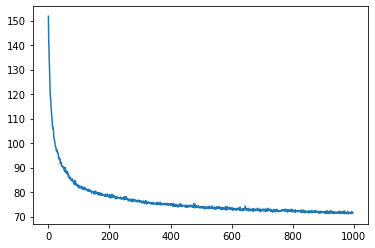

In [86]:
plt.plot(losses[2:])

In [84]:

# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation
    for batch_inputs, batch_targets in data_loader:
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        test_loss += loss.item() * batch_inputs.size(0)  # Accumulate the loss

# Calculate the average test loss
test_loss /= len(data_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0333


In [87]:
ls ..

README.md           main.py             param.py            utils.py
__pycache__/        maps/               result_analysis.py
biriskrrt.py        models/             results/
data/               notebooks/          riskrrt.py


In [88]:
torch.save(model.state_dict(), '../results/trained_models/fc_0.03_0525.pt')

# inference pipeline